# 貓狗分類問題（Pytorch）Resnet18版本

### 準備動作（導入模組）

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

### 下載模型/預設GPU

In [2]:
#download the pretrained model
import torchvision.models as models
model = models.resnet18(pretrained = True)
model

#switch device to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 加載資料路徑

In [4]:
train_dir = 'input/train/train'
test_dir = 'input/test1/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

### 定義數據集

In [5]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import torchvision

class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

### 資料轉變

In [6]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

### 從訓練集中儲存貓和狗的數據

In [7]:
cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

### 加載貓狗數據集，一個批次64筆資料，且打亂順序

In [11]:
dataloader = DataLoader(catdogs, batch_size = 64, shuffle=True)

### 隨機列出訓練集中的貓狗圖片

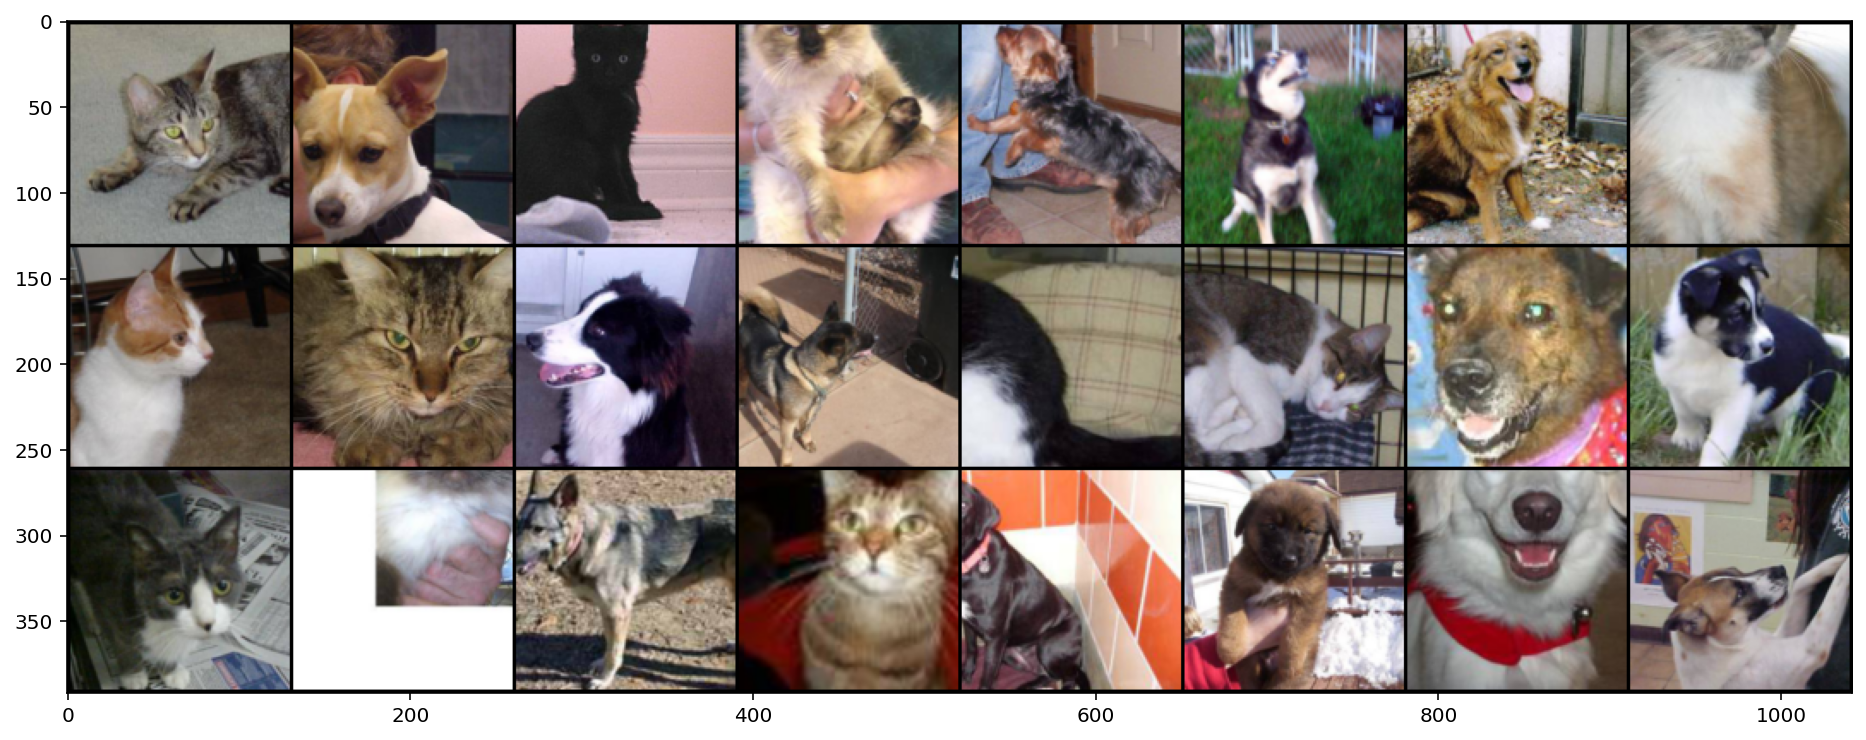

In [12]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

### 只訓練分類器

In [13]:
# Freeze the parameters 
for param in model.parameters():
    param.requires_grad = False 

### 預設神經網路

In [14]:
#Classifier architecture to put on top of resnet18
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc

In [15]:
#shifting model to gpu
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 訓練模型，深度為10層，并印出損失函數

Epoch : 1/10.. Training Loss: 0.298681
Epoch : 2/10.. Training Loss: 0.189565
Epoch : 3/10.. Training Loss: 0.169964
Epoch : 4/10.. Training Loss: 0.159765
Epoch : 5/10.. Training Loss: 0.168712
Epoch : 6/10.. Training Loss: 0.157473
Epoch : 7/10.. Training Loss: 0.146344
Epoch : 8/10.. Training Loss: 0.151827
Epoch : 9/10.. Training Loss: 0.158038
Epoch : 10/10.. Training Loss: 0.143037


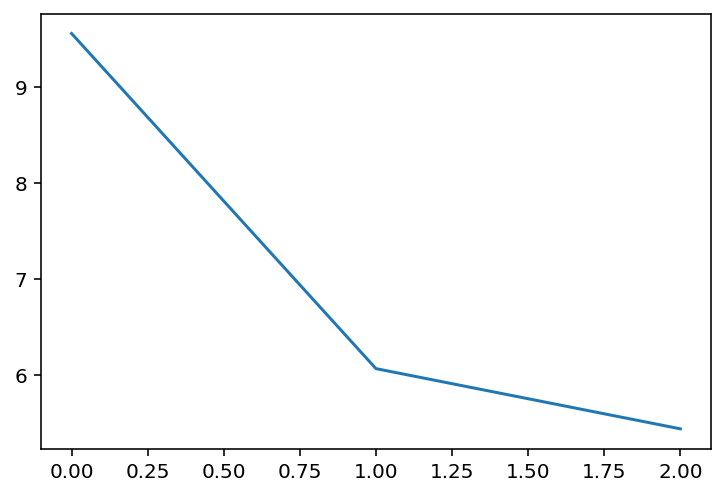

In [16]:
#function to train the model
def train(model, trainloader, criterion, optimizer, epochs = 5):
    train_loss =[]

    for e in range(epochs):
        running_loss =0
        for images, labels in trainloader:

            inputs, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            img = model(inputs)

            loss = criterion(img, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()

        print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss: {:.6f}".format(running_loss/len(trainloader))) 
        train_loss.append(running_loss)
    

    plt.plot([train_loss[0].cpu().detach().numpy(), train_loss[1].cpu().detach().numpy(), train_loss[2].cpu().detach().numpy()], label="Training Loss")
    plt.show()
    
    
    
epochs = 10
model.train()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.NLLLoss()    
train(model,dataloader,criterion, optimizer, epochs) 

### 儲存成功訓練的模型

In [23]:
#Save the model
filename_pth = 'ckpt_resnet18_catdog.pth'
torch.save(model.state_dict(), filename_pth)


#Transform the test dataset
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 100, shuffle=False)

### 預設了一百張測試資料，通過模型預測並印出結果

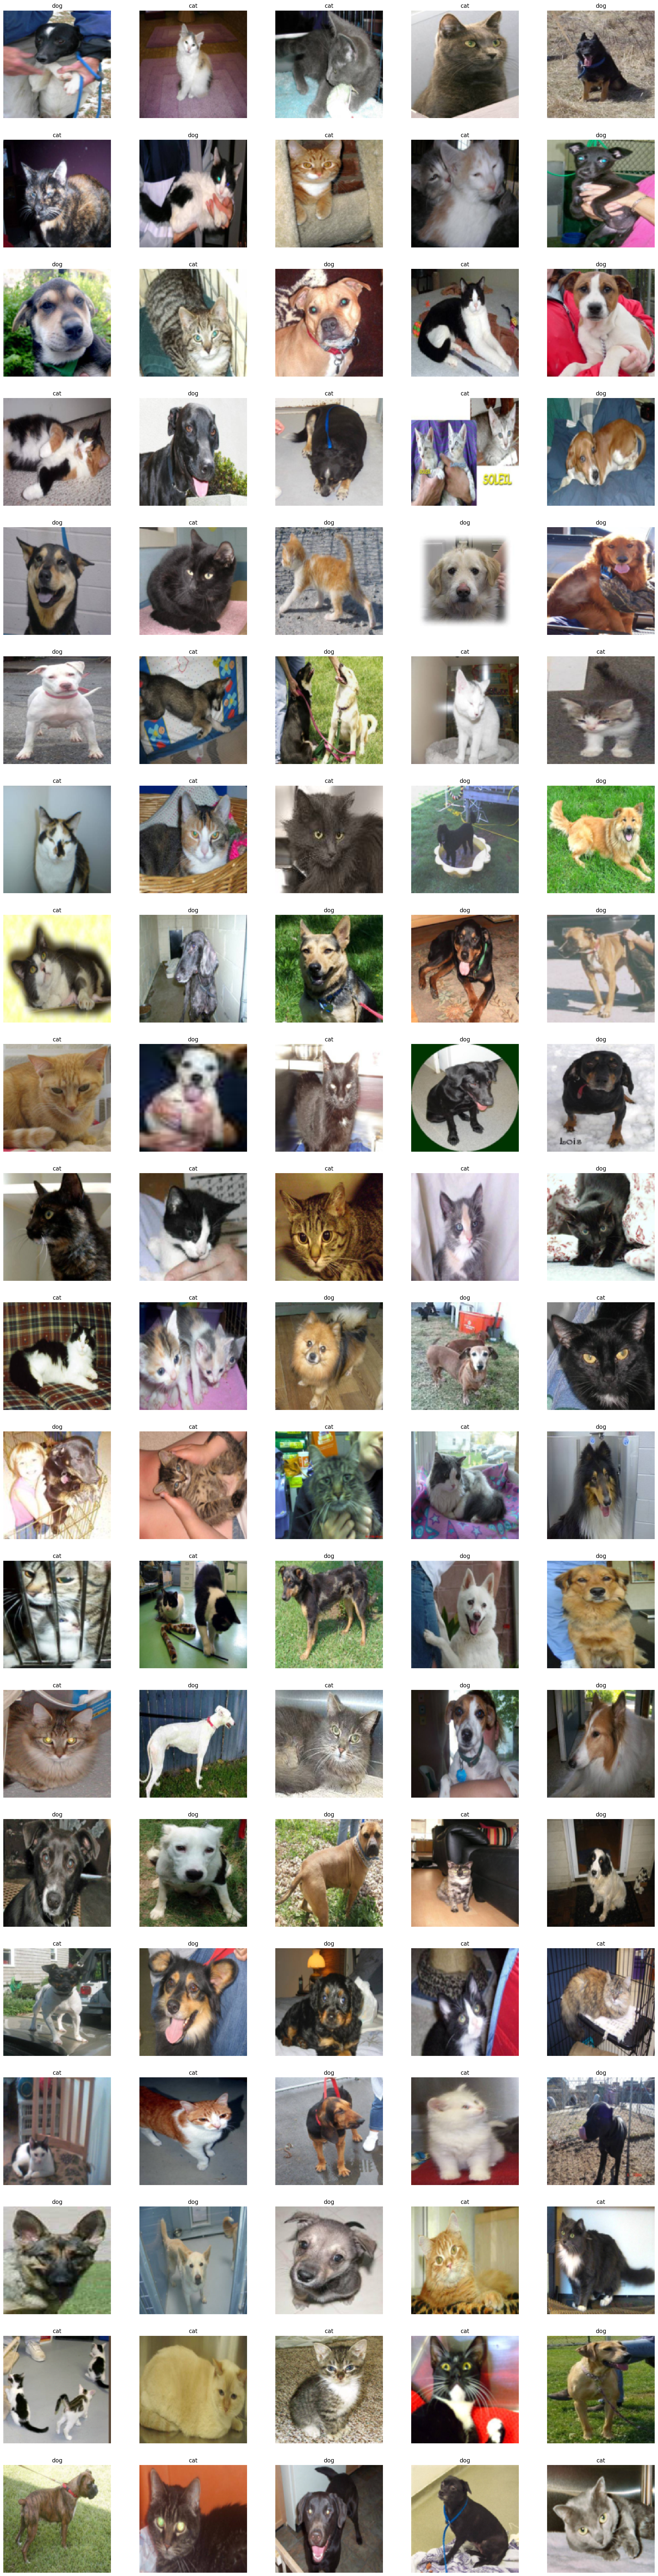

In [62]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(25, 100))
fig.tight_layout()
output = model(samples[:])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:]):
    plt.subplot(20,5,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

### 測試的結果儲存為csv文件

In [66]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('preds_resnet18.csv', index=False)

### 把預測的結果和實際的結果做對比，判斷預測成功率

In [80]:
import csv

with open('true_test.csv', 'r') as f:
    true_test = {}
    reader = csv.reader(f)
    for row in reader:
        true_test = {rows[0]:rows[1] for rows in reader}

with open('preds_resnet18.csv', 'r') as f:
    preds_test = {}
    reader = csv.reader(f)
    preds_test = {rows[0]:rows[1] for rows in reader}

sum = 0
for i in range(1, 101):
    if true_test[str(i)] == preds_test[str(i)]:
        sum += 1
        
print("預測成功概率:\n{:.2f}%".format(sum))

預測成功概率:
93.00%


# 最終結果，預測成功的概率高達百分之九十三